In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from datetime import datetime

from sklearn.externals import joblib

from sklearn.metrics import mean_squared_error
from scipy.fftpack import fft

%matplotlib inline

In [2]:
energy = pd.read_csv('data/production_consumption_2012_2016_scaled.csv', sep=';', decimal=',')
energy['timestamp'] = pd.to_datetime(energy['cet_cest_timestamp'])
energy.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1, inplace=True)
energy.set_index('timestamp', inplace=True)

energy_train = energy[(energy.index >= datetime(2012,1,1)) & (energy.index < datetime(2016,1,1))]
energy_test = energy[(energy.index >= datetime(2016,1,1)) & (energy.index < datetime(2017,1,1))]

In [3]:
weather_b = pd.read_csv('data/weather_UTC_2012-2016_Berlin.csv', sep=';', decimal=',')
weather_b.VALUE_TIME = pd.to_datetime(weather_b.VALUE_TIME)
weather_b.set_index('VALUE_TIME', inplace=True)
weather_b_train = weather_b[(weather_b.index>=datetime(2012, 1, 1)) & (weather_b.index < datetime(2016,1,1))]
weather_b_test = weather_b[(weather_b.index>=datetime(2016, 1, 1)) & (weather_b.index < datetime(2017,1,1))]

weather_m = pd.read_csv('data/weather_UTC_2012-2016_Munich.csv', sep=';', decimal=',')
weather_m.VALUE_TIME = pd.to_datetime(weather_m.VALUE_TIME)
weather_m.set_index('VALUE_TIME', inplace=True)
weather_m_train = weather_m[(weather_m.index>=datetime(2012, 1, 1)) & (weather_m.index < datetime(2016,1,1))]
weather_m_test = weather_m[(weather_m.index>=datetime(2016, 1, 1)) & (weather_m.index < datetime(2017,1,1))]

weather_d = pd.read_csv('data/weather_UTC_2012-2016_Dusseldorf.csv', sep=';', decimal=',')
weather_d.VALUE_TIME = pd.to_datetime(weather_d.VALUE_TIME)
weather_d.set_index('VALUE_TIME', inplace=True)
weather_d_train = weather_d[(weather_d.index>=datetime(2012, 1, 1)) & (weather_d.index < datetime(2016,1,1))]
weather_d_test = weather_d[(weather_d.index>=datetime(2016, 1, 1)) & (weather_d.index < datetime(2017,1,1))]

## Solar Prediction

In [4]:
x_train = np.array(pd.concat([weather_m_train[['global_rad']], weather_b_train[['global_rad']], 
                              weather_d_train[['global_rad']]], axis=1))
                   
x_test = np.array(pd.concat([weather_m_test[['global_rad']], weather_b_test[['global_rad']], 
                              weather_d_test[['global_rad']]], axis=1))

# Split the targets into training/testing sets
y_train = np.array(energy_train['solarprod']).reshape(-1,1)
y_test = np.array(energy_test['solarprod']).reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Solar Prediction
solar_pred = regr.predict(x_test)

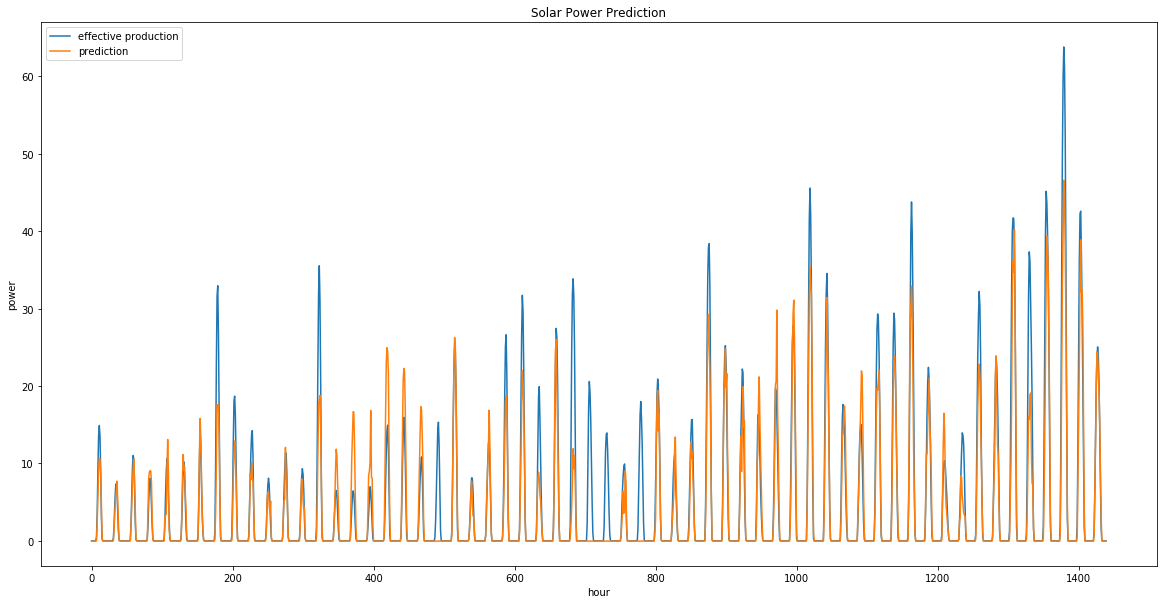

In [5]:
plt.figure(figsize=(20,10))
plt.title('Solar Power Prediction')
plt.plot(y_test[:24*60], label='effective production')
plt.plot(solar_pred[:24*60], label='prediction')
plt.xlabel('hour')
plt.ylabel('power')
plt.legend()

In [6]:
regr.score(x_test[1:], y_test)

0.90387982557539004

In [7]:
out = energy_test[['solarprod']].reset_index()
out['solar_prediction'] = solar_pred[1:]
out.to_csv('prediction/sun.csv', index=None)

In [8]:
joblib.dump(regr, 'models/solar_prediction_model.sav')

['models/solar_prediction_model.sav']

## Wind Prediction

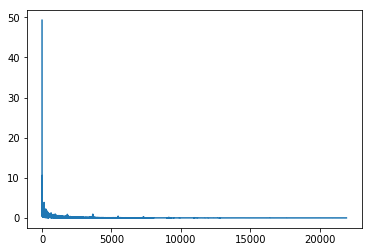

In [6]:
yf = fft(np.array(energy[(energy.index >= datetime(2012,1,1)) & (energy.index < datetime(2017,1,1))]['windprod']))
N = len(yf)
plt.plot(2.0/N * np.abs(yf[0:N//2]))

In [7]:
yf

array([ 1079713.92762900     +0.j        ,
          33619.40270130+168184.61991097j,
         -35912.90310919 +63125.66563953j, ...,
          15848.56467345 +18592.13160993j,
         -35912.90310919 -63125.66563953j,
          33619.40270130-168184.61991097j])

In [8]:
# Split the data into training/testing sets
x_train = np.array(pd.concat([weather_m_train[['wind_speed_10m']], weather_b_train[['wind_speed_10m']],
                              weather_d_train[['wind_speed_10m']]], axis=1))

x_test = np.array(pd.concat([weather_m_test[['wind_speed_10m']], weather_b_test[['wind_speed_10m']],
                              weather_d_test[['wind_speed_10m']]], axis=1))

# Split the targets into training/testing sets
y_train = np.array(energy_train['windprod']).reshape(-1,1)
y_test = np.array(energy_test['windprod']).reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Wind Prediction
wind_pred = regr.predict(x_test)

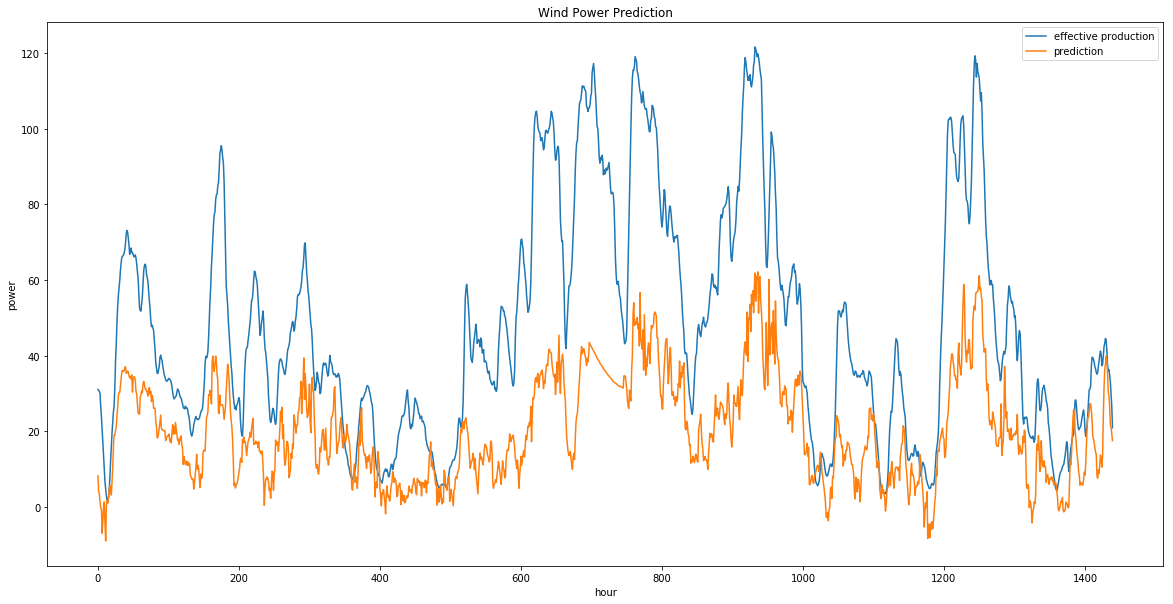

In [9]:
plt.figure(figsize=(20,10))
plt.title('Wind Power Prediction')
plt.plot(y_test[:24*60], label='effective production')
plt.plot(wind_pred[:24*60], label='prediction')
plt.xlabel('hour')
plt.ylabel('power')
plt.legend()

In [35]:
regr.score(x_test[1:], y_test)

-0.054974430566741457

In [38]:
mean_squared_error(y_test, wind_pred[:-1]) 

648.23701701318328

In [12]:
out = energy_test[['windprod']].reset_index()
out['wind_prediction'] = wind_pred[1:]
out.to_csv('prediction/wind.csv', index=None)

In [13]:
joblib.dump(regr, 'models/wind_prediction_model.sav')

['models/wind_prediction_model.sav']

## Production Prediction

In [6]:
# Split the data into training/testing sets
x_train = np.array(pd.concat([weather_m_train[['global_rad','wind_speed_10m','precip_1h','t_2m']], 
                              weather_b_train[['global_rad','wind_speed_10m','precip_1h', 't_2m']],
                              weather_d_train[['global_rad','wind_speed_10m','precip_1h', 't_2m']], 
                              ], axis=1))

x_test = np.array(pd.concat([weather_m_test[['global_rad','wind_speed_10m','precip_1h', 't_2m']], 
                             weather_b_test[['global_rad','wind_speed_10m','precip_1h', 't_2m']],
                              weather_d_test[['global_rad','wind_speed_10m','precip_1h', 't_2m']]
                            ], axis=1))

# Split the targets into training/testing sets
y_train = np.array(energy_train[['solarprod','windprod']])#.reshape(-1,1)
y_test = np.array(energy_test[['solarprod','windprod']])#.reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Wind Prediction
production_pred = regr.predict(x_test)

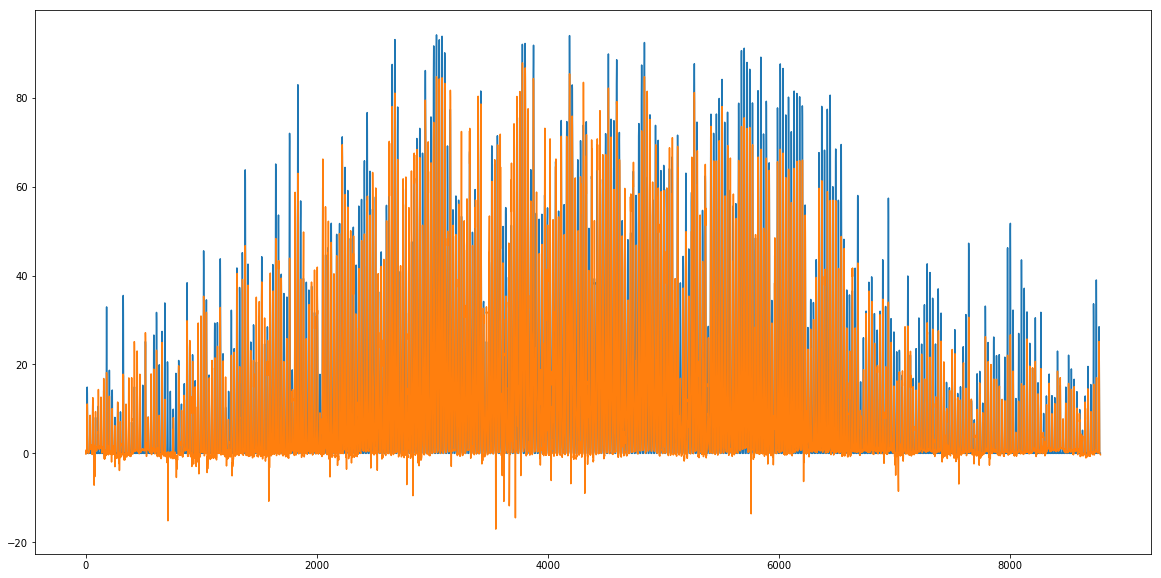

In [9]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:, 0], label='solar')
plt.plot(production_pred[:,0], label='solar_pred')

In [13]:
mean_squared_error(y_test[:,0], production_pred[:-1,0]) 

37.512497053352639

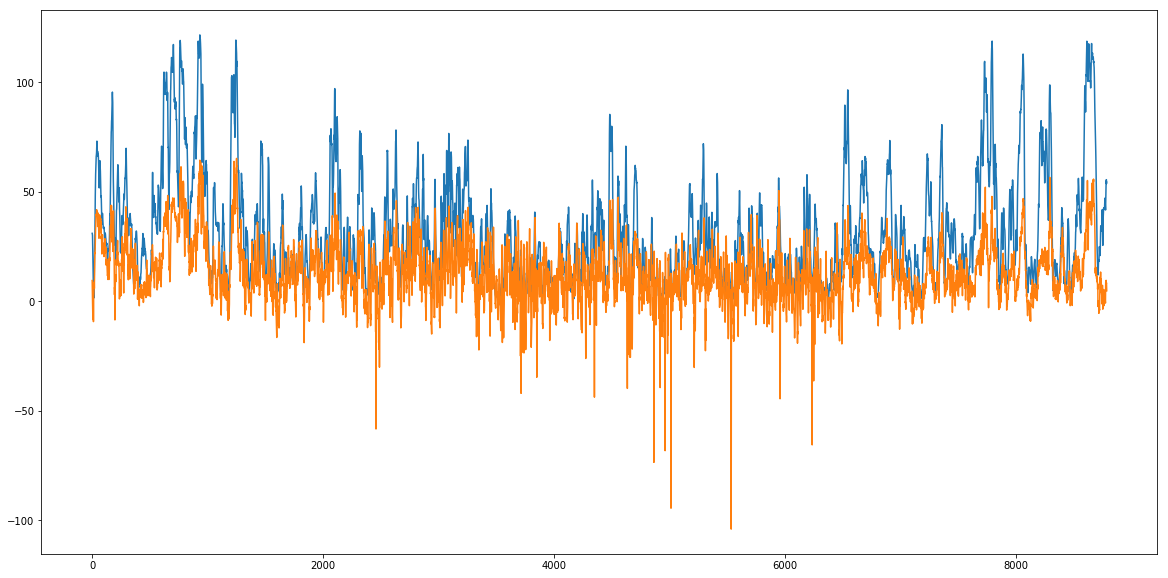

In [10]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:, 1], label='wind')
plt.plot(production_pred[:,1], label='wind')

In [14]:
mean_squared_error(y_test[:,1], production_pred[:-1,1]) 

648.11063585796569